# UPV: Utility scale PV

This dataset consists of 1 year (2006) of 5-minute solar power (mW) for 137 photovoltaic power plants in Alabama State.

## The Challenge?

The data was for power generation from photovoltaic plants in a similar geographic condition, with only differentiating factor named on the files being the Latitude and Longitude.

Hence, the approach taken is taking the actual values for single plant and analysis and prediction is done. This analysis will hold true for most of the other plants.



In [162]:
!pip install meteostat

In [316]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import tensorflow as tf
import matplotlib.dates as mdates
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
# Import necessary libraries
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

## Reading and Processing the data:

In [269]:
df = pd.read_csv('/content/Actual_32.65_-85.85_2006_UPV_30MW_5_Min.csv')

In [270]:
df_dpv = pd.read_csv('/content/Actual_32.65_-86.15_2006_DPV_27MW_5_Min.csv')

In [271]:
df.head()

,LocalTime,Power(MW)
0,01/01/06 00:00,0.0
1,01/01/06 00:05,0.0
2,01/01/06 00:10,0.0
3,01/01/06 00:15,0.0
4,01/01/06 00:20,0.0


In [272]:
df_dpv.head()

,LocalTime,Power(MW)
0,01/01/06 00:00,0.0
1,01/01/06 00:05,0.0
2,01/01/06 00:10,0.0
3,01/01/06 00:15,0.0
4,01/01/06 00:20,0.0


In [273]:
# Ensure the Timestamp column is a datetime object
df["LocalTime"] = pd.to_datetime(df["LocalTime"])

In [274]:
df.values

array([[Timestamp('2006-01-01 00:00:00'), 0.0],
       [Timestamp('2006-01-01 00:05:00'), 0.0],
       [Timestamp('2006-01-01 00:10:00'), 0.0],
       ...,
       [Timestamp('2006-12-31 23:45:00'), 0.0],
       [Timestamp('2006-12-31 23:50:00'), 0.0],
       [Timestamp('2006-12-31 23:55:00'), 0.0]], dtype=object)

# Exploratory Data Analysis (EDA)

## Converting to Hourly Data:

In [275]:
# Resample to hourly frequency, taking the mean of each hour
hourly_df = df.resample('H', on='LocalTime').sum()

# If you want to use another aggregation function (e.g. sum, max, min)
# hourly_df = df.resample('H', on='LocalTime').sum()

print(hourly_df.head())

                     Power(MW)
LocalTime                     
2006-01-01 00:00:00        0.0
2006-01-01 01:00:00        0.0
2006-01-01 02:00:00        0.0
2006-01-01 03:00:00        0.0
2006-01-01 04:00:00        0.0


In [276]:
hourly_df.head(24)

,Power(MW)
LocalTime,
2006-01-01 00:00:00,0.0
2006-01-01 01:00:00,0.0
2006-01-01 02:00:00,0.0
2006-01-01 03:00:00,0.0
2006-01-01 04:00:00,0.0
2006-01-01 05:00:00,0.0
2006-01-01 06:00:00,0.0
2006-01-01 07:00:00,35.9
2006-01-01 08:00:00,36.2


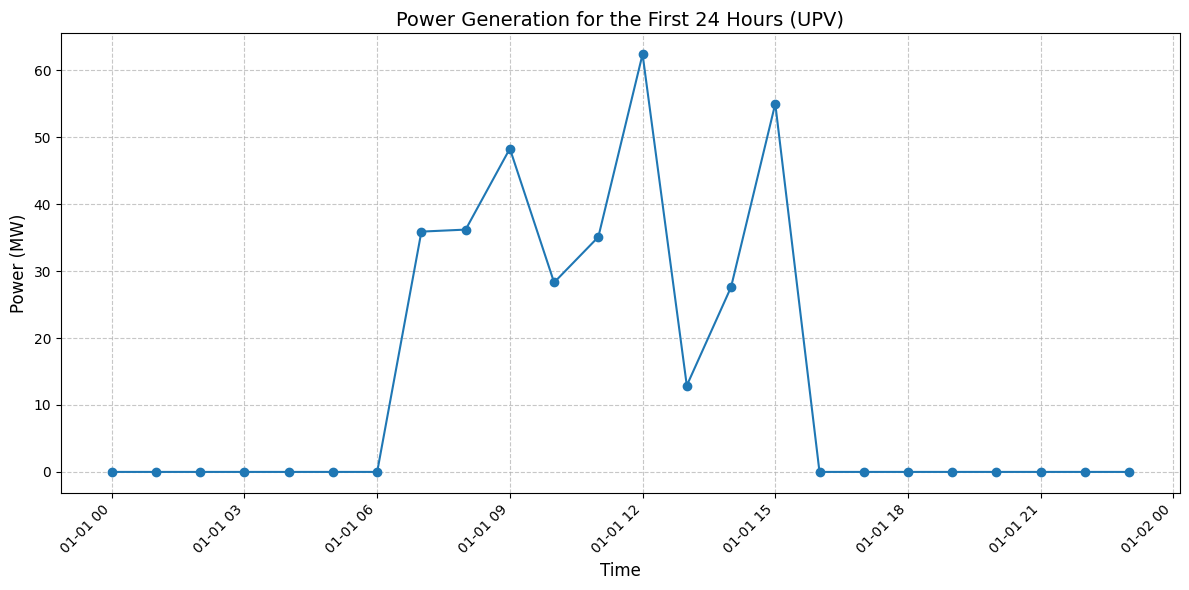

In [277]:
# Plot the first 24 hours of data
plt.figure(figsize=(12, 6))
plt.plot(hourly_df.head(24).index, hourly_df.head(24)['Power(MW)'], marker='o', linestyle='-')  # Added markers and linestyle
plt.xlabel("Time", fontsize=12) # Increased fontsize
plt.ylabel("Power (MW)", fontsize=12)
plt.title("Power Generation for the First 24 Hours (UPV)", fontsize=14) # Increased fontsize
plt.xticks(rotation=45, ha='right') # Aligned x-axis labels
plt.grid(True, linestyle='--', alpha=0.7) # Added grid
plt.tight_layout()
plt.show()

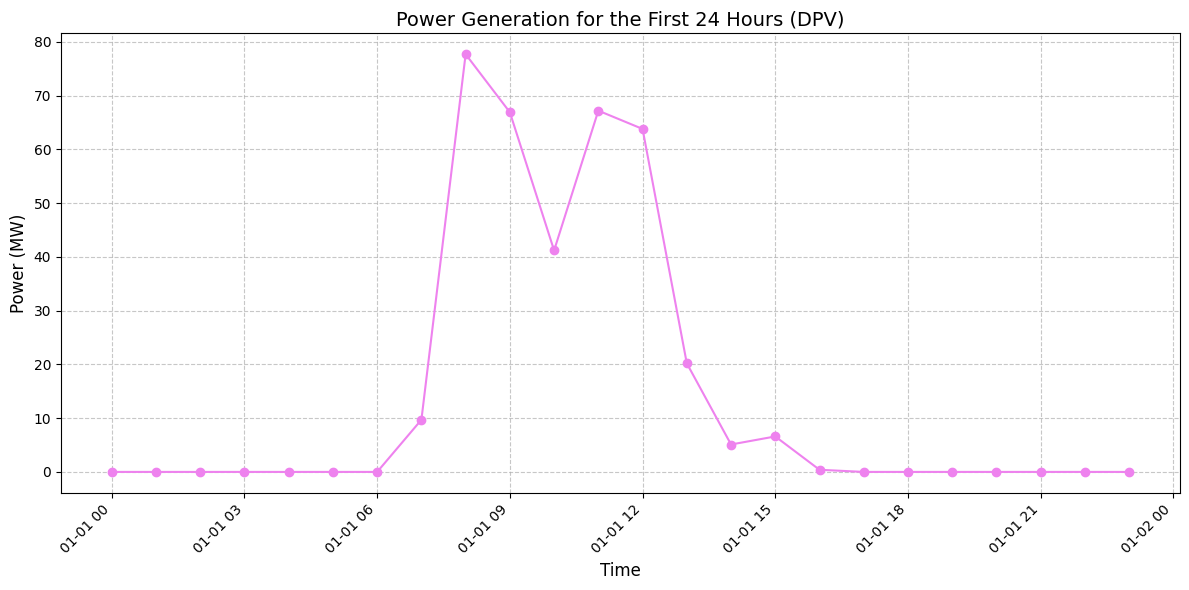

In [278]:
# Ensure the Timestamp column is a datetime object
df_dpv["LocalTime"] = pd.to_datetime(df_dpv["LocalTime"])

# Resample to hourly frequency, taking the mean of each hour
hourly_df_dpv = df_dpv.resample('H', on='LocalTime').sum()

# Plot the first 24 hours of data
plt.figure(figsize=(12, 6))
plt.plot(hourly_df_dpv.head(24).index, hourly_df_dpv.head(24)['Power(MW)'], marker='o', linestyle='-', color='violet')  # Added markers and linestyle
plt.xlabel("Time", fontsize=12) # Increased fontsize
plt.ylabel("Power (MW)", fontsize=12)
plt.title("Power Generation for the First 24 Hours (DPV)", fontsize=14) # Increased fontsize
plt.xticks(rotation=45, ha='right') # Aligned x-axis labels
plt.grid(True, linestyle='--', alpha=0.7) # Added grid
plt.tight_layout()
plt.show()

**Key Insights:**

1. The graph shows a clear peak in power generation around the 12-hour mark, which is expected due to the sun's position and maximum solar radiation at midday.

2. The overall shape of the curve reveals a strong diurnal pattern with low generation during early morning and late evening hours, and a rapid increase towards midday followed by a gradual decrease.

3. Even within the peak generation period, there is noticeable variability in power output. This could be attributed to factors like cloud cover, atmospheric conditions, and solar insolation.

In [279]:
hourly_df = hourly_df.reset_index()

# Convert the 'LocalTime' column to datetime objects.
hourly_df['LocalTime'] = pd.to_datetime(hourly_df['LocalTime'])

# Display the first few rows of the updated DataFrame to verify the changes.
hourly_df.head()

,LocalTime,Power(MW)
0,2006-01-01 00:00:00,0.0
1,2006-01-01 01:00:00,0.0
2,2006-01-01 02:00:00,0.0
3,2006-01-01 03:00:00,0.0
4,2006-01-01 04:00:00,0.0


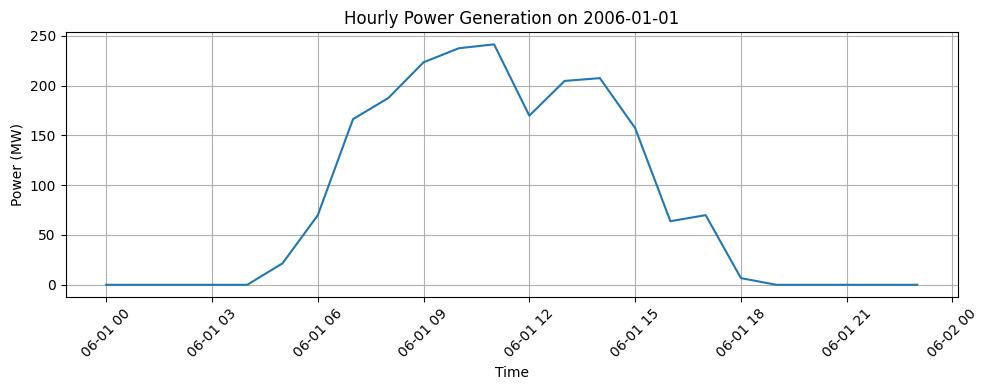

In [280]:
# Select data for a specific day (e.g., 2006-01-01)
# Assuming LocalTime is a datetime column
specific_day_data = hourly_df[hourly_df['LocalTime'].dt.date == pd.to_datetime('2006-06-01').date()]


# Create the line plot
plt.figure(figsize=(10, 4))  # Adjust figure size as needed
plt.plot(specific_day_data['LocalTime'], specific_day_data['Power(MW)'])

# Customize the plot
plt.xlabel("Time")
plt.ylabel("Power (MW)")
plt.title("Hourly Power Generation on 2006-01-01")
plt.grid(True)  # Add a grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


## Summer vs Winter?

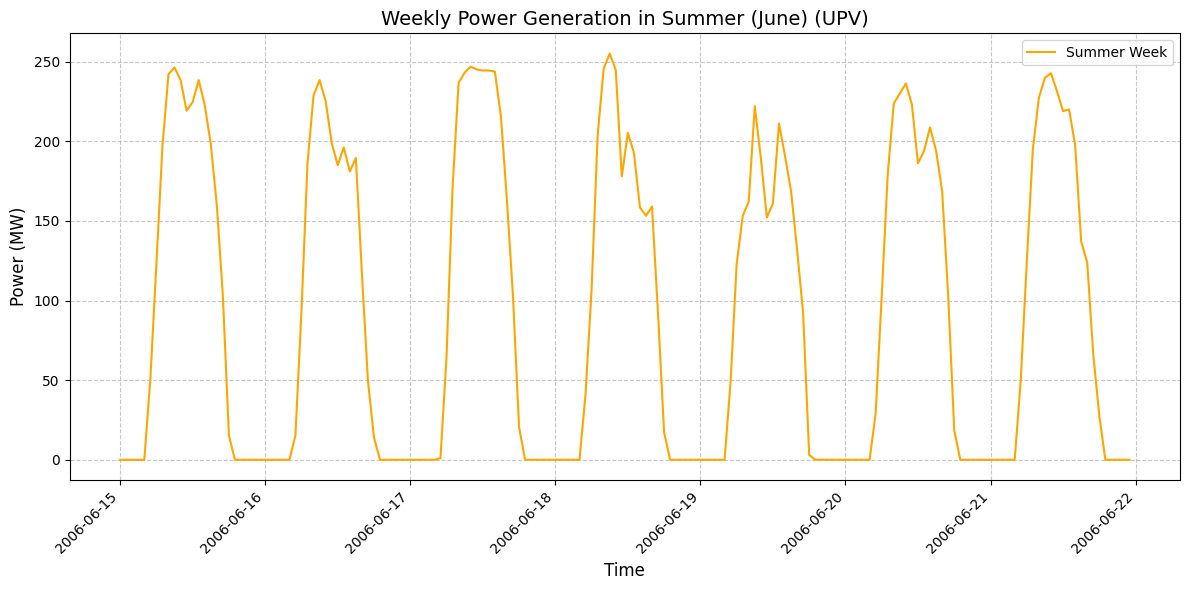

In [281]:
# Select data for a week in summer (e.g., June)
summer_week_data = hourly_df[(hourly_df['LocalTime'].dt.date >= pd.to_datetime('2006-06-15').date()) & (hourly_df['LocalTime'].dt.date < pd.to_datetime('2006-06-22').date())]

# Create the summer plot
plt.figure(figsize=(12, 6))
plt.plot(summer_week_data['LocalTime'], summer_week_data['Power(MW)'], color='orange', label='Summer Week')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.title("Weekly Power Generation in Summer (June) (UPV)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

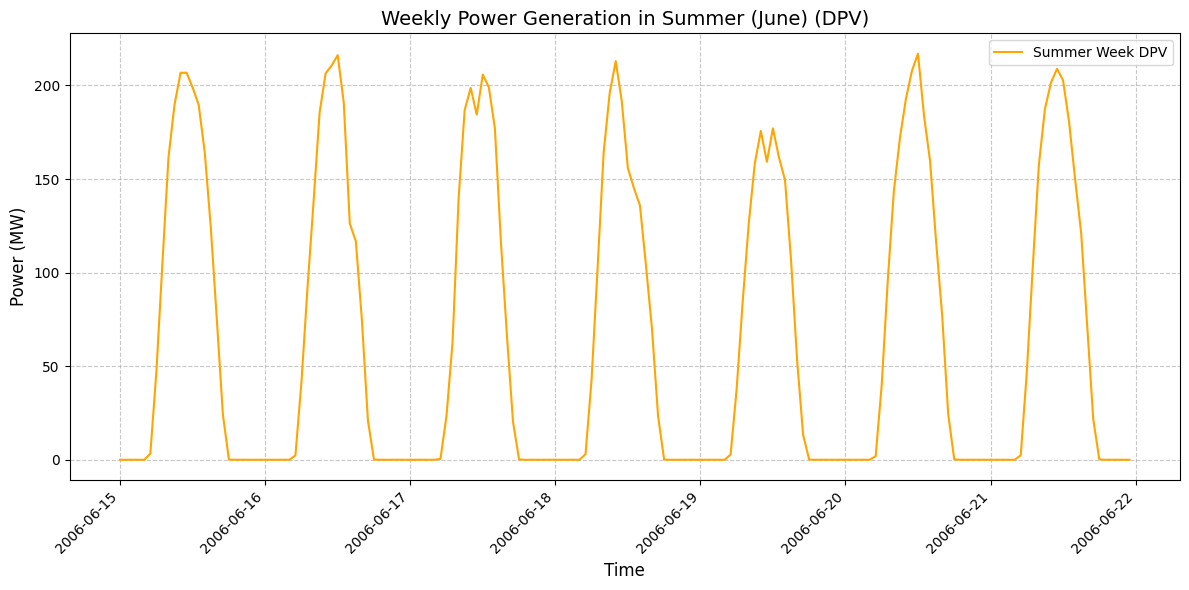

In [282]:
# Select data for a week in summer (e.g., June) for DPV data
summer_week_data_dpv = hourly_df_dpv[(hourly_df_dpv.index.date >= pd.to_datetime('2006-06-15').date()) & (hourly_df_dpv.index.date < pd.to_datetime('2006-06-22').date())]

# Create the summer plot for DPV data
plt.figure(figsize=(12, 6))
plt.plot(summer_week_data_dpv.index, summer_week_data_dpv['Power(MW)'], color='orange', label='Summer Week DPV')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.title("Weekly Power Generation in Summer (June) (DPV)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

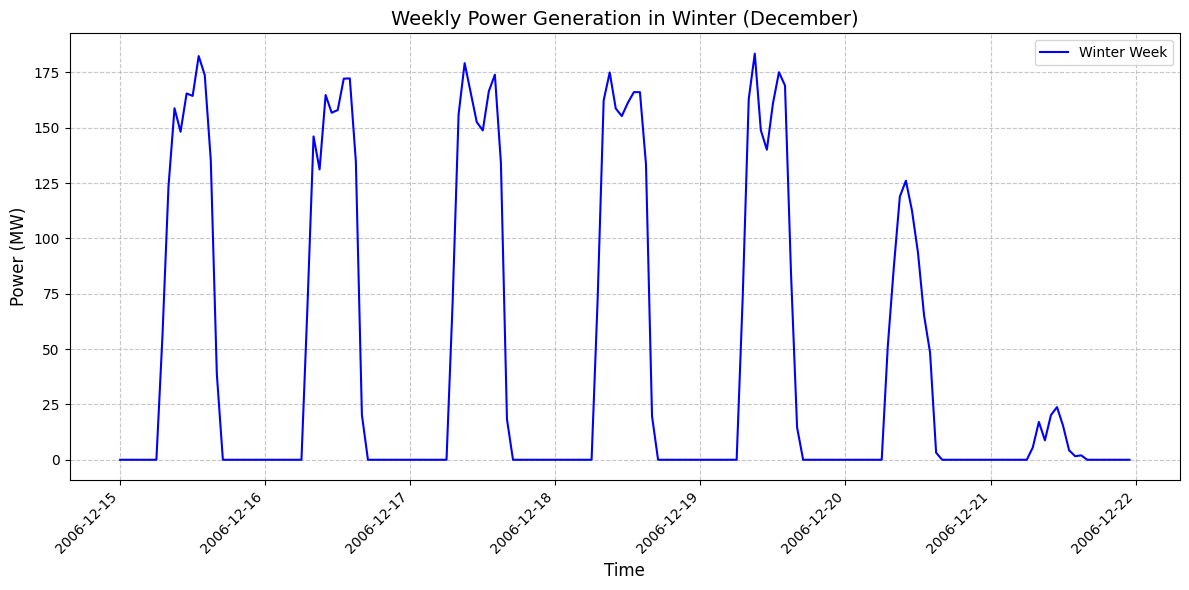

In [283]:
# Select data for a week in winter (e.g., December)
winter_week_data = hourly_df[(hourly_df['LocalTime'].dt.date >= pd.to_datetime('2006-12-15').date()) & (hourly_df['LocalTime'].dt.date < pd.to_datetime('2006-12-22').date())]

# Create the winter plot
plt.figure(figsize=(12, 6))
plt.plot(winter_week_data['LocalTime'], winter_week_data['Power(MW)'], color='blue', label='Winter Week')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.title("Weekly Power Generation in Winter (December)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

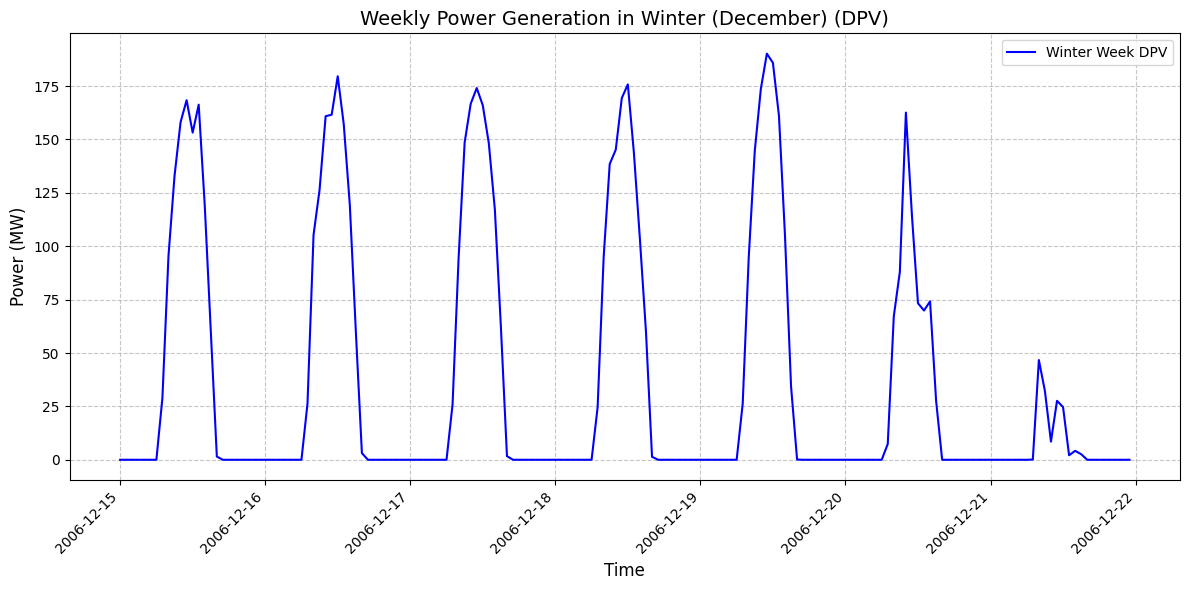

In [284]:
# Select data for a week in winter (e.g., December) for DPV data
winter_week_data_dpv = hourly_df_dpv[(hourly_df_dpv.index.date >= pd.to_datetime('2006-12-15').date()) & (hourly_df_dpv.index.date < pd.to_datetime('2006-12-22').date())]

# Create the winter plot for DPV data
plt.figure(figsize=(12, 6))
plt.plot(winter_week_data_dpv.index, winter_week_data_dpv['Power(MW)'], color='blue', label='Winter Week DPV')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.title("Weekly Power Generation in Winter (December) (DPV)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

**Key Differences between Summer and Winter Power Generation:**

1. The winter graph shows significantly lower peak generation levels compared to the summer graph. This is likely due to the reduced solar radiation during winter months.

2. While both graphs exhibit a diurnal pattern with peaks during daylight hours and minimal generation at night, the winter curve is less pronounced. The summer graph shows a more distinct and taller peak, indicating higher generation during peak solar hours.

3. The winter graph appears to show more variability in generation levels compared to the summer graph. This could be due to factors like cloud cover, atmospheric conditions, and changes in weather patterns during winter, which can significantly impact solar power output.

## Hourly Analysis:

<Figure size 1600x600 with 0 Axes>

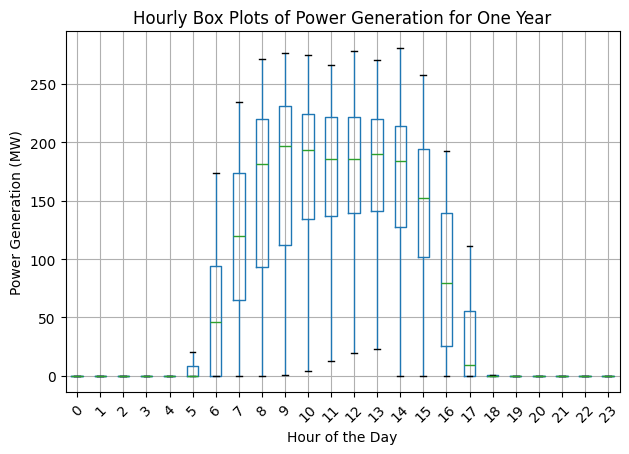

In [285]:
# Extract the hour from the LocalTime column
hourly_df['Hour'] = hourly_df['LocalTime'].dt.hour

# Create the box plots
plt.figure(figsize=(16, 6))  # Adjust figure size as needed
hourly_df.boxplot(column='Power(MW)', by='Hour', grid=True, showfliers=False) #showfliers=False removes outliers


plt.xlabel("Hour of the Day")
plt.ylabel("Power Generation (MW)")
plt.title("Hourly Box Plots of Power Generation for One Year")
plt.suptitle('') # remove the default boxplot title
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key points from the hourly box plots of power generation for one year:**

1. Daytime Peak: Power generation is highest during the middle of the day.
2. Morning and Evening Low: Generation is lowest in the early morning and late evening.
3. Lots of Variation: There's a lot of fluctuation in power output, especially during the peak hours.

In [286]:
# Descriptive statistics
print(hourly_df['Power(MW)'].describe())

count    8760.000000
mean       67.585514
std        87.888725
min         0.000000
25%         0.000000
50%         0.000000
75%       149.700000
max       280.800000
Name: Power(MW), dtype: float64


## Annual Plot of Daily Generation:

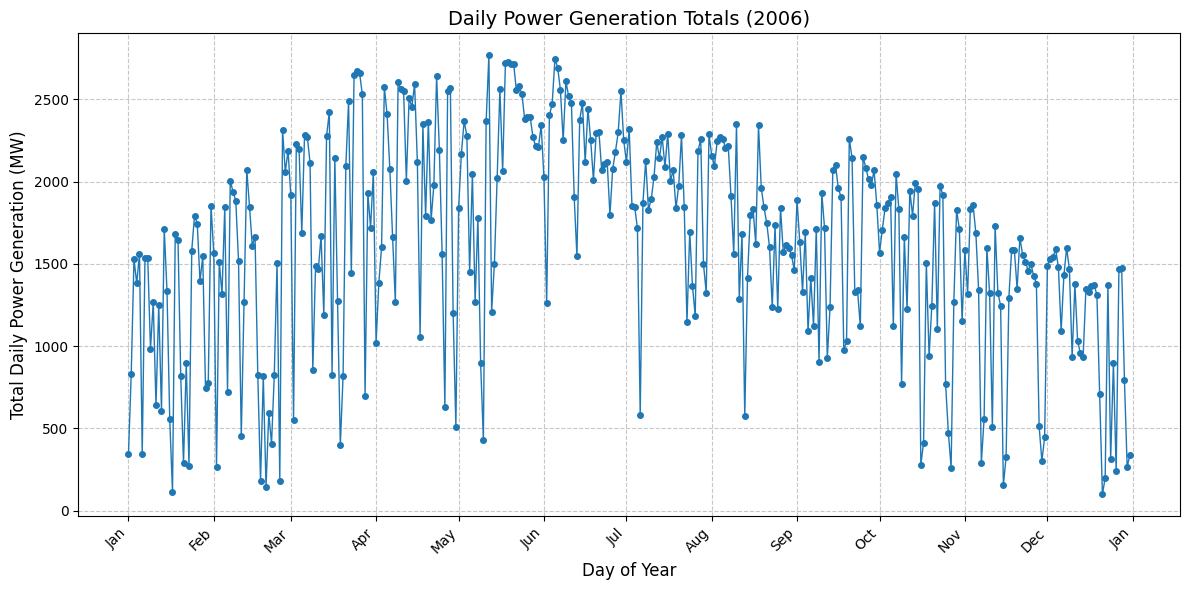

In [287]:
# Daily totals
daily_totals = hourly_df.groupby(hourly_df['LocalTime'].dt.date)['Power(MW)'].sum()

plt.figure(figsize=(12, 6))  # Increased figure size for better readability
plt.plot(daily_totals.index, daily_totals.values, marker='o', linestyle='-', linewidth=1, markersize=4) # Added marker and line customization

# Customize plot elements
plt.xlabel("Day of Year", fontsize=12)
plt.ylabel("Total Daily Power Generation (MW)", fontsize=12)
plt.title("Daily Power Generation Totals (2006)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)  # Added grid

# Format the x-axis to show dates more clearly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Abbreviated month names
plt.gcf().autofmt_xdate(rotation=45) # Rotate date labels for better readability


plt.tight_layout()
plt.show()

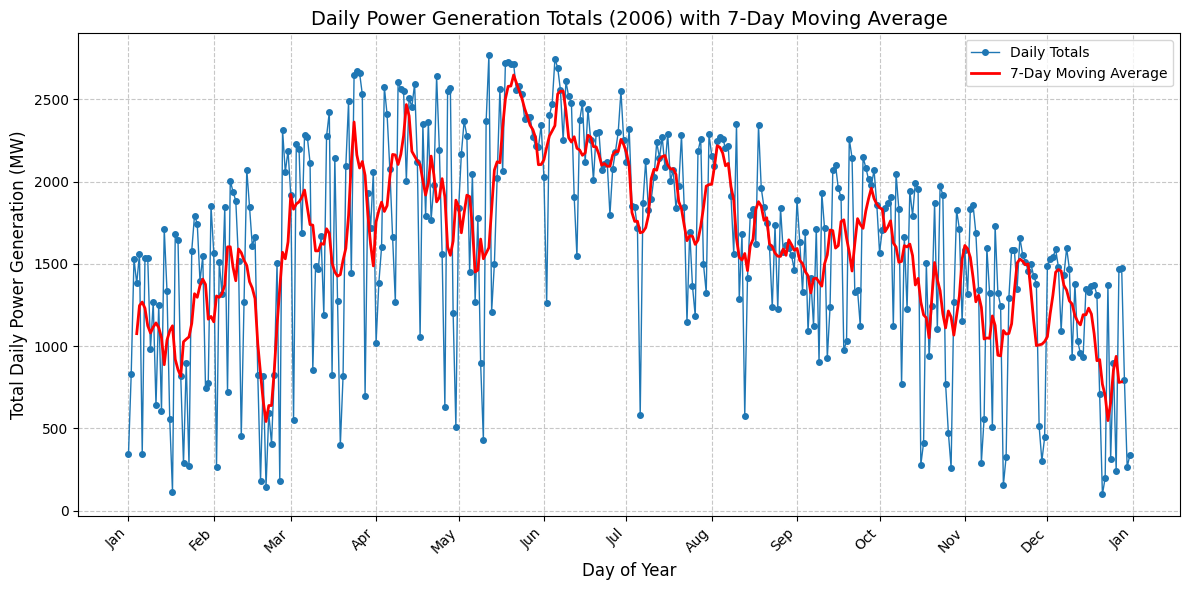

In [288]:
# Calculate the 7-day moving average
daily_totals_rolling = daily_totals.rolling(window=7,center=True).mean()

# Plotting the original data and the 7-day moving average
plt.figure(figsize=(12, 6))
plt.plot(daily_totals.index, daily_totals.values, label='Daily Totals', marker='o', linestyle='-', linewidth=1, markersize=4)
plt.plot(daily_totals_rolling.index, daily_totals_rolling.values, label='7-Day Moving Average', color='red', linewidth=2)

plt.xlabel("Day of Year", fontsize=12)
plt.ylabel("Total Daily Power Generation (MW)", fontsize=12)
plt.title("Daily Power Generation Totals (2006) with 7-Day Moving Average", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gcf().autofmt_xdate(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

**Key Observations:**

1. The graph shows a clear seasonal pattern in power generation.  We can see a significant increase in power generation during the summer months (around June to August) and a decrease during the winter months (December to February). This is likely due to the increased solar radiation and longer daylight hours during summer.

2. Even within the summer months, there are fluctuations in daily power generation. This could be attributed to factors such as cloud cover, weather conditions, and variations in solar irradiance.

In [289]:
len(daily_totals)

365

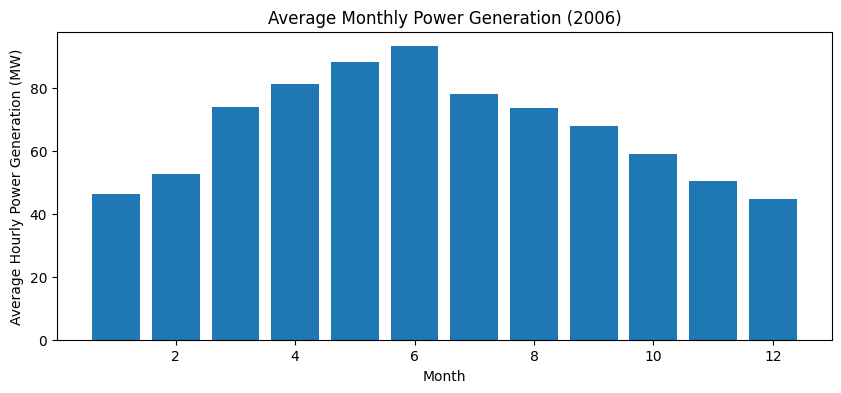

In [290]:
# Monthly averages
monthly_averages = hourly_df.groupby(hourly_df['LocalTime'].dt.month)['Power(MW)'].mean()
plt.figure(figsize=(10, 4))
plt.bar(monthly_averages.index, monthly_averages.values)
plt.xlabel("Month")
plt.ylabel("Average Hourly Power Generation (MW)")
plt.title("Average Monthly Power Generation (2006)")
plt.show()

**Key Insights:**

1. Power generation shows a strong seasonal trend, with higher output during summer months and lower output during winter months.

2. The highest average power generation occurs in June and July, likely due to increased solar radiation and longer daylight hours in summer.

3. Average generation is lowest in December and January, reflecting the reduced solar radiation and shorter daylight hours in winter.

4. The graph shows a gradual transition from high summer generation to low winter generation, suggesting a smooth seasonal change in power output.

5. The data in this graph can be used to predict future power generation trends, which is valuable for grid management and planning.

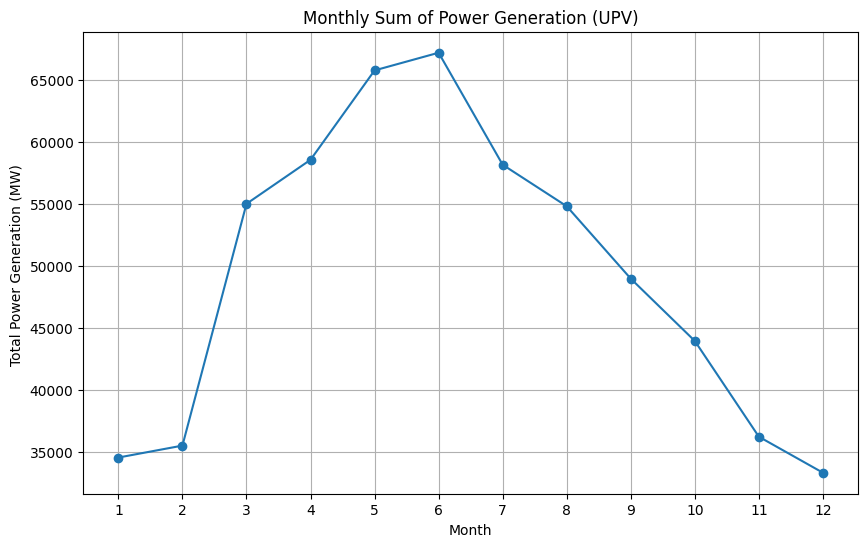

In [291]:

# Calculate monthly sums
monthly_sums = hourly_df.groupby(hourly_df['LocalTime'].dt.month)['Power(MW)'].sum()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_sums.index, monthly_sums.values, marker='o', linestyle='-')  # Added markers and line style
plt.xlabel("Month")
plt.ylabel("Total Power Generation (MW) ")
plt.title("Monthly Sum of Power Generation (UPV)")
plt.xticks(monthly_sums.index)  # Ensure all month labels are displayed
plt.grid(True)
plt.show()

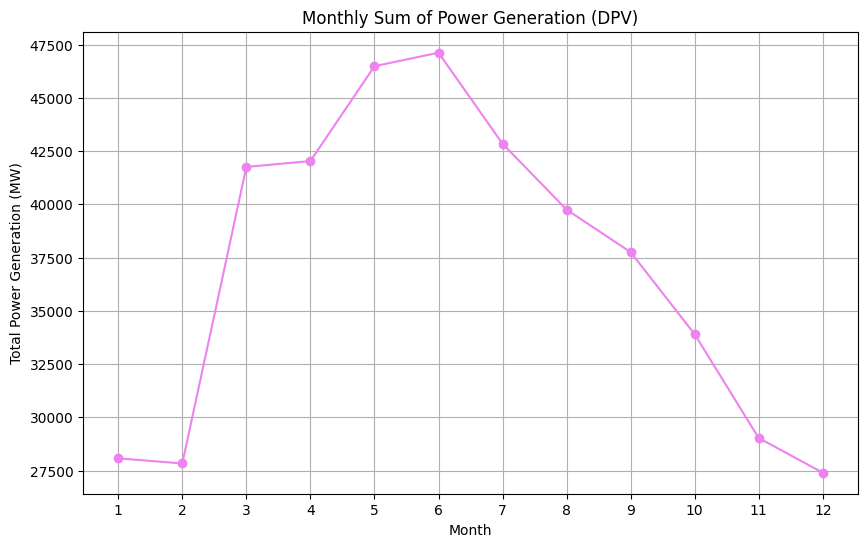

In [292]:
# Calculate monthly sums for DPV data
monthly_sums_dpv = hourly_df_dpv.groupby(hourly_df_dpv.index.month)['Power(MW)'].sum()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_sums_dpv.index, monthly_sums_dpv.values, marker='o', linestyle='-', color='violet')  # Added markers and line style
plt.xlabel("Month")
plt.ylabel("Total Power Generation (MW)")
plt.title("Monthly Sum of Power Generation (DPV)")
plt.xticks(monthly_sums_dpv.index)  # Ensure all month labels are displayed
plt.grid(True)
plt.show()

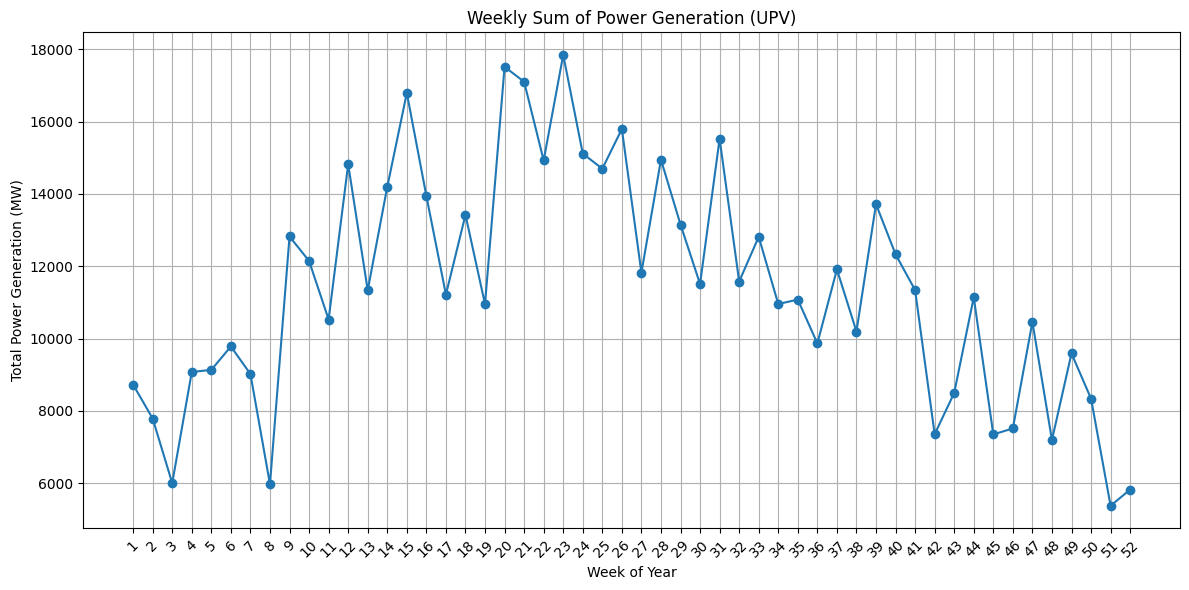

In [293]:
# Calculate weekly sums
weekly_sums = hourly_df.groupby(hourly_df['LocalTime'].dt.isocalendar().week)['Power(MW)'].sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_sums.index, weekly_sums.values, marker='o', linestyle='-')
plt.xlabel("Week of Year")
plt.ylabel("Total Power Generation (MW)")
plt.title("Weekly Sum of Power Generation (UPV)")
plt.xticks(weekly_sums.index, rotation=45) # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

The graph shows significant fluctuations in weekly power generation throughout the year. There are significant peaks in the Summer Season.

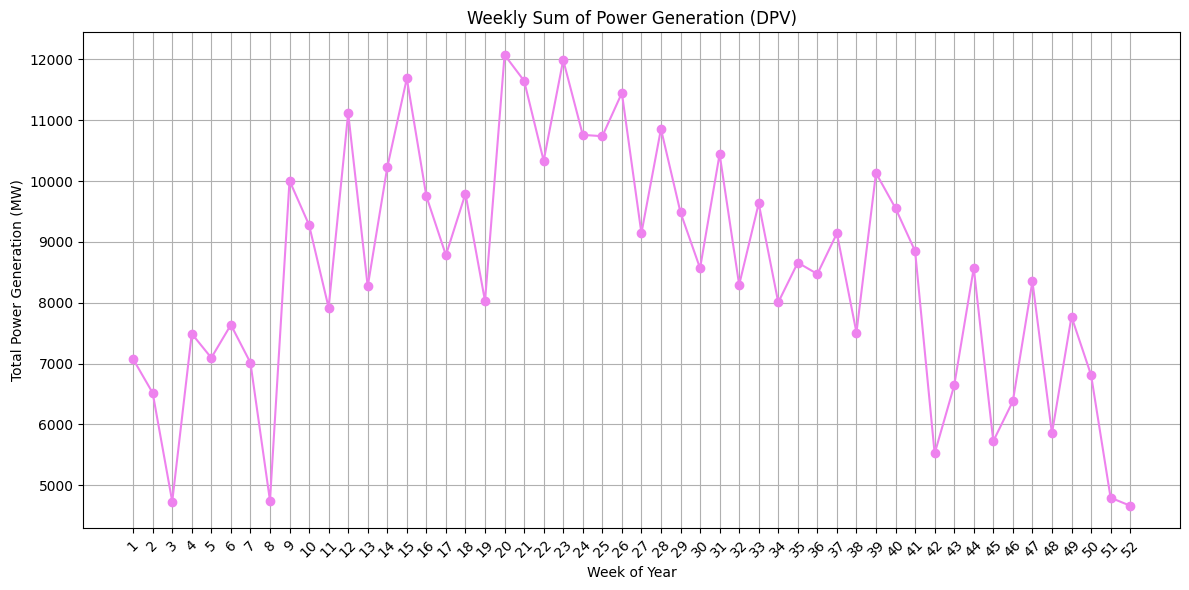

In [294]:
# Calculate weekly sums for DPV data
weekly_sums_dpv = hourly_df_dpv.groupby(hourly_df_dpv.index.isocalendar().week)['Power(MW)'].sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_sums_dpv.index, weekly_sums_dpv.values, marker='o', linestyle='-', color='violet')
plt.xlabel("Week of Year")
plt.ylabel("Total Power Generation (MW)")
plt.title("Weekly Sum of Power Generation (DPV)")
plt.xticks(weekly_sums_dpv.index, rotation=45) # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Next what?

1. **Similar seasonal trends:** Both UPV and DPV datasets exhibit a clear seasonal pattern, with higher power generation during summer months and lower generation during winter months. This is because of the longer daylight hours and increased solar irradiance in summer.

2. **Consistent diurnal patterns:**  Both datasets demonstrate a strong diurnal cycle, with peak power output around midday and minimal generation at night. This aligns with the sun's position and the availability of sunlight throughout the day.

3. **Correlated variations:** While there might be some minor differences in the magnitude of power generation between UPV and DPV, the overall trends and variations appear to be highly correlated.  This suggests that the underlying factors influencing power output (solar irradiance, weather conditions) affect both types of plants similarly.

4. **Reduced data redundancy:**  Using only UPV data avoids redundancy and simplifies the analysis and modeling process, as the DPV data provides largely similar information with less noise.  This is particularly true when resources are constrained.

# Feature Engineering:

# Getting weather data

In [296]:
# prompt: given the latitude and longitude, can you gather hourly weather data for a location
from datetime import datetime, timedelta

from meteostat import Point, Hourly

# Replace with your desired latitude and longitude
latitude = 32.65
longitude = -85.85

# Set time period
start = datetime(2006, 1, 1, 0, 0)  # Start date and time
end = datetime(2006, 12, 31, 23, 59) # End date and time

# Create Point for location
location = Point(latitude, longitude)

# Get hourly data
data = Hourly(location, start, end)
data = data.fetch()

In [297]:
data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2006-01-01 00:00:00,11.0,4.0,62.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2006-01-01 01:00:00,8.0,4.9,81.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2006-01-01 02:00:00,7.0,5.0,87.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2006-01-01 03:00:00,6.0,4.0,87.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2006-01-01 04:00:00,5.0,4.0,93.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


## Taking the Temperature and Relative Humidity Data for that location

In [298]:
# Select only 'temp' and 'rhum' columns
data = data[['temp', 'rhum']]

In [299]:
data.head()

,temp,rhum
time,,
2006-01-01 00:00:00,11.0,62.0
2006-01-01 01:00:00,8.0,81.0
2006-01-01 02:00:00,7.0,87.0
2006-01-01 03:00:00,6.0,87.0
2006-01-01 04:00:00,5.0,93.0


In [300]:
data = data.reset_index()

# Convert the 'LocalTime' column to datetime objects.
data['time'] = pd.to_datetime(data['time'])

# Display the first few rows of the updated DataFrame to verify the changes.
data.head()

,time,temp,rhum
0,2006-01-01 00:00:00,11.0,62.0
1,2006-01-01 01:00:00,8.0,81.0
2,2006-01-01 02:00:00,7.0,87.0
3,2006-01-01 03:00:00,6.0,87.0
4,2006-01-01 04:00:00,5.0,93.0


In [301]:
hourly_df.head()

,LocalTime,Power(MW),Hour
0,2006-01-01 00:00:00,0.0,0
1,2006-01-01 01:00:00,0.0,1
2,2006-01-01 02:00:00,0.0,2
3,2006-01-01 03:00:00,0.0,3
4,2006-01-01 04:00:00,0.0,4


## Merging the data:

In [302]:
# Merge the two dataframes based on the time column
final_data = pd.merge(hourly_df, data, left_on='LocalTime', right_on='time', how='left')

# Display the first few rows of the merged dataframe
print(final_data.head())


            LocalTime  Power(MW)  Hour                time  temp  rhum
0 2006-01-01 00:00:00        0.0     0 2006-01-01 00:00:00  11.0  62.0
1 2006-01-01 01:00:00        0.0     1 2006-01-01 01:00:00   8.0  81.0
2 2006-01-01 02:00:00        0.0     2 2006-01-01 02:00:00   7.0  87.0
3 2006-01-01 03:00:00        0.0     3 2006-01-01 03:00:00   6.0  87.0
4 2006-01-01 04:00:00        0.0     4 2006-01-01 04:00:00   5.0  93.0


In [303]:
# Drop the 'time' column
final_data = final_data.drop('time', axis=1)

# Display the first few rows of the updated DataFrame
print(final_data.head())

            LocalTime  Power(MW)  Hour  temp  rhum
0 2006-01-01 00:00:00        0.0     0  11.0  62.0
1 2006-01-01 01:00:00        0.0     1   8.0  81.0
2 2006-01-01 02:00:00        0.0     2   7.0  87.0
3 2006-01-01 03:00:00        0.0     3   6.0  87.0
4 2006-01-01 04:00:00        0.0     4   5.0  93.0


In [304]:
# Fill numerical missing values with ffill
numerical_cols = final_data.select_dtypes(include=['number']).columns
final_data[numerical_cols] = final_data[numerical_cols].ffill()

In [305]:
final_data.head()

,LocalTime,Power(MW),Hour,temp,rhum
0,2006-01-01 00:00:00,0.0,0,11.0,62.0
1,2006-01-01 01:00:00,0.0,1,8.0,81.0
2,2006-01-01 02:00:00,0.0,2,7.0,87.0
3,2006-01-01 03:00:00,0.0,3,6.0,87.0
4,2006-01-01 04:00:00,0.0,4,5.0,93.0


In [306]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   LocalTime  8760 non-null   datetime64[ns]
 1   Power(MW)  8760 non-null   float64       
 2   Hour       8760 non-null   int32         
 3   temp       8760 non-null   float64       
 4   rhum       8760 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(1)
memory usage: 308.1 KB


## Fetch hourly solar irradiance data for a given latitude, longitude, and date range.

In [307]:
import requests
import datetime

def fetch_solar_irradiance(lat, lon, start_date, end_date):
    """
    Fetch hourly solar irradiance data for a given latitude, longitude, and date range.

    Args:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        start_date (str): Start date in the format 'YYYYMMDD'.
        end_date (str): End date in the format 'YYYYMMDD'.

    Returns:
        dict: Solar irradiance data or error message.
    """
    base_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start": start_date,
        "end": end_date,
        "parameters": "ALLSKY_SFC_SW_DWN",  # Solar irradiance parameter
        "community": "RE",
        "format": "JSON",
        "user": "anonymous"
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise an error for bad status codes
        data = response.json()
        return data.get('properties', {}).get('parameter', {}).get('ALLSKY_SFC_SW_DWN', {})
    except requests.exceptions.RequestException as e:
        return {"error": str(e)}

# Example usage
latitude = 32.65  # Replace with your latitude
longitude = -85.85  # Replace with your longitude
start_date = "20060101"  # Start date in YYYYMMDD
end_date = "20061231"  # End date in YYYYMMDD

solar_data = fetch_solar_irradiance(latitude, longitude, start_date, end_date)


In [308]:
solar_df = pd.DataFrame(list(solar_data.items()), columns=['Time', 'SolarIrradiance'])
solar_df['Time'] = pd.to_datetime(solar_df['Time'], format='%Y%m%d%H')

In [309]:
solar_df.head()

,Time,SolarIrradiance
0,2006-01-01 00:00:00,0.0
1,2006-01-01 01:00:00,0.0
2,2006-01-01 02:00:00,0.0
3,2006-01-01 03:00:00,0.0
4,2006-01-01 04:00:00,0.0


In [310]:
# Merge the two dataframes based on the time column
final_df = pd.merge(final_data, solar_df, left_on='LocalTime', right_on='Time', how='left')

# Display the first few rows of the merged dataframe
print(final_df.head())

# Drop the 'Time' column
final_df = final_df.drop('Time', axis=1)

            LocalTime  Power(MW)  Hour  temp  rhum                Time  \
0 2006-01-01 00:00:00        0.0     0  11.0  62.0 2006-01-01 00:00:00   
1 2006-01-01 01:00:00        0.0     1   8.0  81.0 2006-01-01 01:00:00   
2 2006-01-01 02:00:00        0.0     2   7.0  87.0 2006-01-01 02:00:00   
3 2006-01-01 03:00:00        0.0     3   6.0  87.0 2006-01-01 03:00:00   
4 2006-01-01 04:00:00        0.0     4   5.0  93.0 2006-01-01 04:00:00   

   SolarIrradiance  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  


In [311]:
# Extract the month from the LocalTime column
final_df['Month'] = final_df['LocalTime'].dt.month

## Final Data with all relevant features:

In [312]:
final_df.head()

,LocalTime,Power(MW),Hour,temp,rhum,SolarIrradiance,Month
0,2006-01-01 00:00:00,0.0,0,11.0,62.0,0.0,1
1,2006-01-01 01:00:00,0.0,1,8.0,81.0,0.0,1
2,2006-01-01 02:00:00,0.0,2,7.0,87.0,0.0,1
3,2006-01-01 03:00:00,0.0,3,6.0,87.0,0.0,1
4,2006-01-01 04:00:00,0.0,4,5.0,93.0,0.0,1


In [313]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   LocalTime        8760 non-null   datetime64[ns]
 1   Power(MW)        8760 non-null   float64       
 2   Hour             8760 non-null   int32         
 3   temp             8760 non-null   float64       
 4   rhum             8760 non-null   float64       
 5   SolarIrradiance  8760 non-null   float64       
 6   Month            8760 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(2)
memory usage: 410.8 KB


# Regression Modelling

## Random Forest

In [319]:
# Select numeric columns and 'Power(MW)' for prediction
numeric_cols = final_df.select_dtypes(include=np.number).columns
numeric_cols = numeric_cols.drop('Power(MW)')
X = final_df[numeric_cols]
y = final_df['Power(MW)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Initialize and train the model
model_rf = RandomForestRegressor(n_estimators=100,# Number of trees in the forest
                              random_state=7,
                              max_depth=20, # Maximum depth of the trees
                              min_samples_split=100,# Minimum number of samples required to split an internal node
                              min_samples_leaf=50 # Minimum number of samples required to be at a leaf node
                              )
model_rf.fit(X_train, y_train)

# Make predictions
y_pred = model_rf.predict(X_test)




In [320]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE (already calculated in your code)
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE (already calculated in your code)
rmse = np.sqrt(mse)

# Calculate R-squared (already calculated in your code)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Coefficient of Determination (R-squared): {r2}")

Mean Absolute Error (MAE): 11.333149591183817
Mean Squared Error (MSE): 464.32667086208596
Root Mean Squared Error (RMSE): 21.548240551425213
Coefficient of Determination (R-squared): 0.9411273112062806


### Perform cross-validation to ensure the model’s stability across different times of the year:

In [321]:
# Prepare data for time series cross-validation
numeric_cols = final_df.select_dtypes(include=np.number).columns
numeric_cols = numeric_cols.drop('Power(MW)')
X = final_df[numeric_cols]
y = final_df['Power(MW)']

# Define the number of splits for time series cross-validation
n_splits = 5  # You can adjust the number of splits

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store evaluation metrics for each fold
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=100, random_state=7, max_depth=20, min_samples_split=100, min_samples_leaf=50)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the scores
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Print the average scores across all folds
print(f"Mean MAE across folds: {np.mean(mae_scores)}")
print(f"Mean MSE across folds: {np.mean(mse_scores)}")
print(f"Mean RMSE across folds: {np.mean(rmse_scores)}")
print(f"Mean R-squared across folds: {np.mean(r2_scores)}")

Mean MAE across folds: 13.284025229954796
Mean MSE across folds: 610.17291798598
Mean RMSE across folds: 24.203144826996187
Mean R-squared across folds: 0.9229926649012559


### Feature Importance:

In [322]:
# Get feature importances
importances = model_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Display feature importances
feature_importances

,feature,importance
3,SolarIrradiance,0.975498
0,Hour,0.019174
2,rhum,0.001952
4,Month,0.001880
1,temp,0.001495


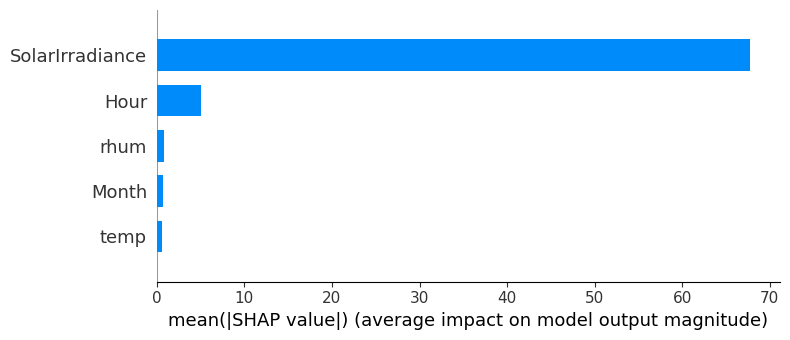

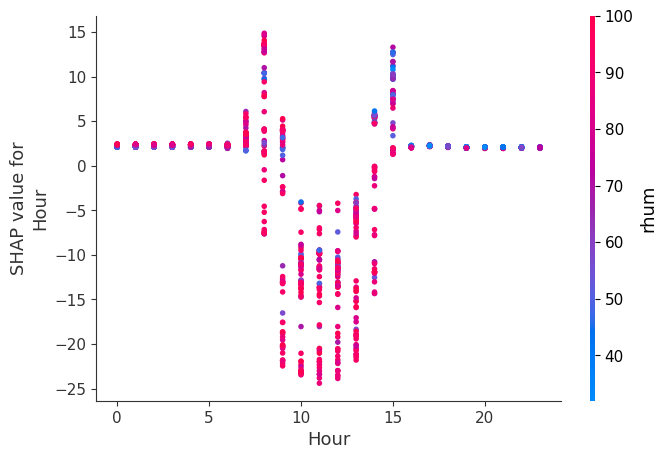

In [323]:
import shap

# Assuming 'model', 'X_test', and 'X_train' are defined from the previous code

# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation (using a force plot)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type="bar")

#Create a SHAP dependence plot
shap.dependence_plot("Hour", shap_values, X_test)

1. **Model Training and Evaluation**: A RandomForestRegressor model is trained using a set of numerical features (temperature, humidity, solar irradiance, hour, month, etc.) to predict power generation ('Power(MW)'). The model's performance is evaluated using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared.  Lower MSE and RMSE indicate better accuracy, while an R-squared closer to 1 signifies a stronger fit to the data.


2. **Feature Importance**:  The code calculates and displays feature importances, indicating the relative contribution of each input feature to the model's predictions. This helps identify the most influential factors affecting power generation. For example, solar irradiance is likely to be highly important.


3. **Hyperparameter Tuning**: The Random Forest model uses specific hyperparameters ( `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, etc.). These parameters control the complexity and performance of the model.  The provided values represent a specific configuration—optimizing these values further could potentially improve the model.


4. **Data Splitting**: The data is split into training and testing sets (70% for training, 30% for testing).  The model is trained on the training data and evaluated on the unseen test data to assess its ability to generalize to new, previously-unobserved data. This helps provide a more realistic evaluation of model performance.




## Neural Network

In [238]:
# Scale the data
scaler_x = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [239]:
# Build the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

In [240]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Mean Absolute Error on test set: {mae}")

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0714 - mae: 0.1849 - val_loss: 0.0116 - val_mae: 0.0710
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - mae: 0.0709 - val_loss: 0.0097 - val_mae: 0.0662
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095 - mae: 0.0634 - val_loss: 0.0095 - val_mae: 0.0599
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088 - mae: 0.0608 - val_loss: 0.0089 - val_mae: 0.0590
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081 - mae: 0.0574 - val_loss: 0.0091 - val_mae: 0.0602
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088 - mae: 0.0617 - val_loss: 0.0088 - val_mae: 0.0604
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081 - mae: 0.0568 - val_loss: 0.0083 - val_mae: 0.0525
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075 - mae: 0.0535 - val_loss: 0.0087 - val_mae: 0.0648
Epoch 9/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [241]:
# Make predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)



83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [242]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE (already calculated in your code)
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE (already calculated in your code)
rmse = np.sqrt(mse)

# Calculate R-squared (already calculated in your code)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Coefficient of Determination (R-squared): {r2}")

Mean Absolute Error (MAE): 12.084832037566017
Mean Squared Error (MSE): 435.889495636614
Root Mean Squared Error (RMSE): 20.87796675053905
Coefficient of Determination (R-squared): 0.9447329041482353


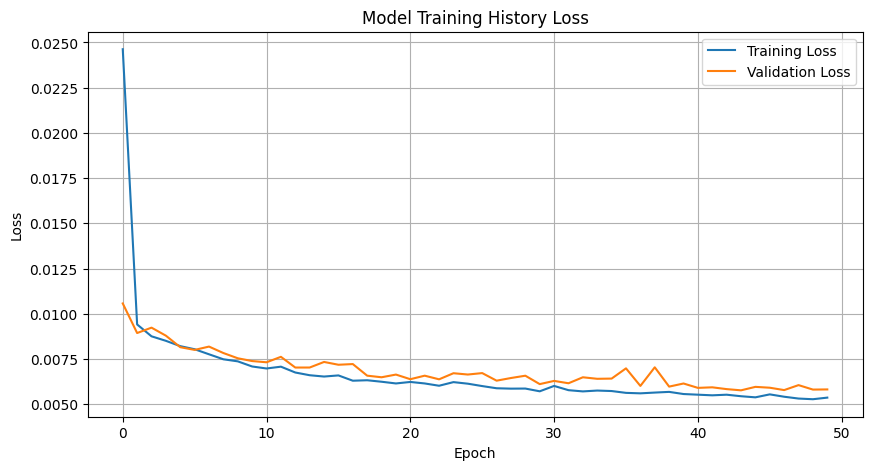

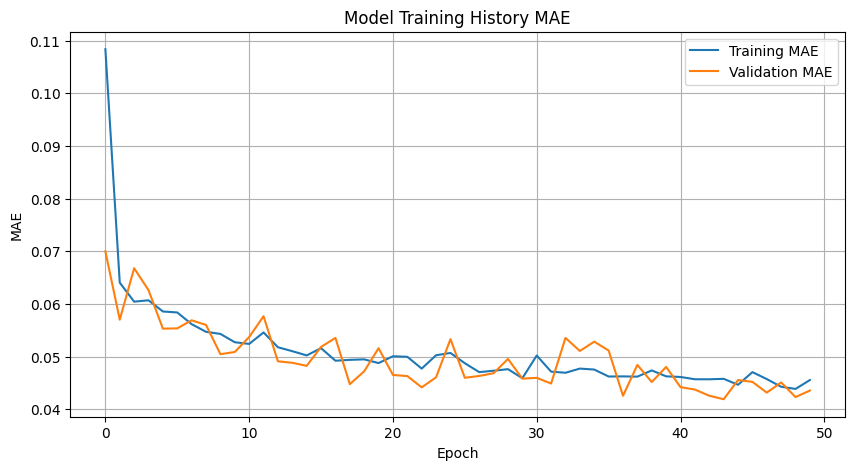

In [215]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training History Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Model Training History MAE')
plt.legend()
plt.grid(True)
plt.show()

1. **Data Scaling**:  The input features (X) and target variable (y, power generation) are scaled using `MinMaxScaler`.  This transforms the features to a specific range (usually 0 to 1), which helps improve the performance and stability of the neural network during training.


2. **Model Architecture**: A sequential neural network with three dense layers is created. The first two layers have ReLU activation functions, which introduce non-linearity. The final layer is a linear output layer (no activation function) as it's predicting a continuous value (power generation).  The number of neurons in each layer (64, 32, 1) and the `'relu'` activation function are choices made by the model creator that can be experimented with to improve model performance.


3. **Model Compilation**: The model is compiled using the Adam optimizer, which is commonly used in neural networks. The loss function is set to Mean Squared Error (MSE), a standard choice for regression tasks. The Mean Absolute Error (MAE) is used as a metric to evaluate the model's performance during training.


4. **Model Training**: The `model.fit()` function trains the neural network using the scaled training data.  Key parameters include the number of epochs (50), batch size (32), and a validation split (0.2). The `validation_split` allocates 20% of the training data for validation during training and helps monitor the model's performance on unseen data.


5. **Model Evaluation**: After training, the model is evaluated on the scaled test data. The Mean Absolute Error (MAE) is reported.  The model's predictions are then inverse-transformed to the original scale of the target variable (power generation), and traditional regression metrics like MSE, RMSE, and R-squared are calculated to provide a more comprehensive performance evaluation.  The results in the original units help interpret the model's accuracy in practical terms.

6. **Training History Visualization**: The code plots the training and validation loss and MAE over epochs to visualize the model's learning curve. This helps identify potential issues like overfitting (when the model performs well on training data but poorly on unseen data), or if additional epochs might improve results.

# **Time Series Analysis**

In [255]:
hourly_df.head()

,LocalTime,Power(MW),Hour
0,2006-01-01 00:00:00,0.0,0
1,2006-01-01 01:00:00,0.0,1
2,2006-01-01 02:00:00,0.0,2
3,2006-01-01 03:00:00,0.0,3
4,2006-01-01 04:00:00,0.0,4


In [256]:
# Prepare the data for Prophet
# Rename columns to 'ds' and 'y' as required by Prophet
hourly_df_prophet = hourly_df.rename(columns={'LocalTime': 'ds', 'Power(MW)': 'y'})

# Split data into training and testing sets (11 months for training, last month for testing)
train_data = hourly_df_prophet[:-720]  # Last month has 30 days * 24 hours = 720 hours
test_data = hourly_df_prophet[-720:]

In [257]:
# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bbxe6i4/y1pcl28j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bbxe6i4/q58ffjo6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68072', 'data', 'file=/tmp/tmp9bbxe6i4/y1pcl28j.json', 'init=/tmp/tmp9bbxe6i4/q58ffjo6.json', 'output', 'file=/tmp/tmp9bbxe6i4/prophet_model_b53_yit/prophet_model-20250117185126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [258]:
# Create future dataframe for prediction
future = model.make_future_dataframe(periods=720, freq='h')  # Predict for the last month (720 hours)

In [259]:
# Make predictions
forecast = model.predict(future)

# Ensure predictions do not go below zero
forecast['yhat'] = forecast['yhat'].clip(lower=0)

In [260]:
# Merge the two dataframes based on the 'ds' column
combined_data = test_data.merge(forecast , on='ds', how='left')

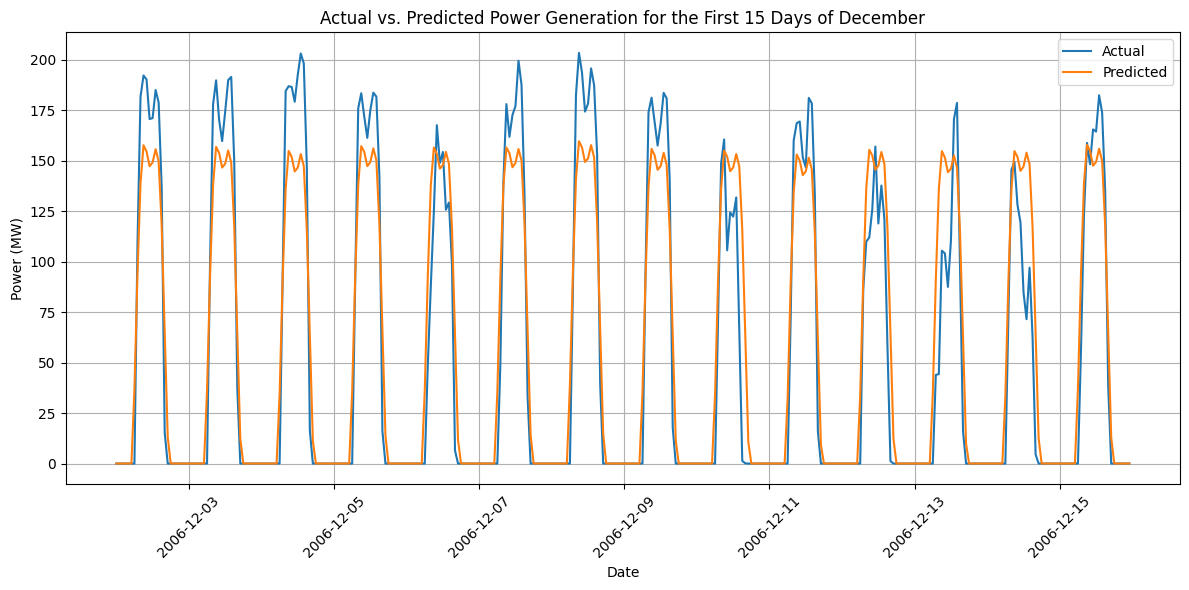

In [261]:
# Filter data for December and the first 15 days
december_data = combined_data[(combined_data['ds'].dt.month == 12) & (combined_data['ds'].dt.day <= 15)]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(december_data['ds'], december_data['y'], label='Actual')
plt.plot(december_data['ds'], december_data['yhat'], label='Predicted')

# Customize the plot
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.title("Actual vs. Predicted Power Generation for the First 15 Days of December")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [262]:
# Filter data for December
december_data = combined_data[combined_data['ds'].dt.month == 12]

In [263]:
# Calculate metrics
mae = mean_absolute_error(december_data['y'], december_data['yhat'])
mse = mean_squared_error(december_data['y'], december_data['yhat'])
rmse = np.sqrt(mse)
r2 = r2_score(december_data['y'], december_data['yhat'])

print(f"December Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

December Metrics:
MAE: 20.723409762269654
MSE: 1476.2372448712226
RMSE: 38.42183291920393
R-squared: 0.6742811472979472


1. **Time Series Forecasting**: Prophet is used for time series forecasting, specifically to predict hourly power generation.  It's designed to handle time series data with strong seasonality and trend components, making it suitable for this application. The code prepares the data by renaming the 'LocalTime' and 'Power(MW)' columns to 'ds' (datestamp) and 'y' (values), respectively, as required by Prophet.

2. **Data Splitting for Evaluation**: The data is split into training and testing sets. The model is trained on 11 months of data, and the last month's data (720 hours) is used as a hold-out test set to assess how well the model generalizes to unseen data.  This allows for an unbiased evaluation of the model's predictive performance.

3. **Model Training and Prediction**:  A Prophet model is initialized and trained using the training data. The `daily_seasonality=True` argument indicates the model will consider daily patterns in the power generation.  The model then makes predictions on the future dataframe created by Prophet, extending the time range for the last month (720 hours).  Crucially, the predictions are clipped to be non-negative, ensuring physically realistic power output values.

4. **Performance Evaluation (R-squared)**: The quality of the Prophet model's predictions is measured using the R-squared metric. This statistic quantifies the proportion of variance in the actual power generation values explained by the model's predictions.  A higher R-squared value (closer to 1) indicates a better fit, implying the model captures the underlying patterns in the data more effectively. The provided code does not display the resulting R-squared value.

5. **Visualization of Results**: A plot compares actual power generation against the predicted values for the first 15 days of December. This visual comparison helps assess the model's accuracy in capturing the short-term fluctuations and overall trends. Deviations between the actual and predicted values provide insight into the model's limitations and potential areas for improvement.

6. **Handling Seasonality**:  Prophet's strength lies in its ability to automatically detect and model seasonality. In this case, the model implicitly learns daily and potentially yearly patterns in the power data.  This automatic seasonality modeling is part of what makes Prophet suitable for tasks where these recurring patterns are important.

## Training Model on Full Year data and Predicting for JAN 2007-MARCH 2007:

In [225]:
# Convert the hourly data to daily data by summing the 'Power(MW)' column
daily_df = hourly_df.groupby(hourly_df['LocalTime'].dt.date)['Power(MW)'].sum().reset_index()

# Rename the 'LocalTime' column to 'Date' for clarity
daily_df.rename(columns={'LocalTime': 'Date'}, inplace=True)

In [226]:
daily_df.head()

,Date,Power(MW)
0,2006-01-01,341.7
1,2006-01-02,832.3
2,2006-01-03,1529.9
3,2006-01-04,1381.5
4,2006-01-05,1560.5


In [227]:
# Prepare the data for Prophet
daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df_prophet = daily_df.rename(columns={'Date': 'ds', 'Power(MW)': 'y'})

# Initialize and fit the Prophet model with yearly seasonality
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True, # Added weekly seasonality
                seasonality_mode='multiplicative') # Changed seasonality mode to multiplicative

model.fit(daily_df_prophet)


# Create future dataframe for prediction (Jan 2007 to March 2007)
future = pd.DataFrame({'ds': pd.date_range(start='2007-01-01', end='2007-03-31')})

# Make predictions
forecast = model.predict(future)

# Ensure predictions do not go below zero
forecast['yhat'] = forecast['yhat'].clip(lower=0)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bbxe6i4/l6_d7w2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9bbxe6i4/x2_yg7zd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58361', 'data', 'file=/tmp/tmp9bbxe6i4/l6_d7w2b.json', 'init=/tmp/tmp9bbxe6i4/x2_yg7zd.json', 'output', 'file=/tmp/tmp9bbxe6i4/prophet_modelj9wqixyx/prophet_model-20250117182527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [228]:
# Display the forecast
print(forecast[['ds', 'yhat']].head())

          ds         yhat
0 2007-01-01   863.073948
1 2007-01-02   912.602531
2 2007-01-03   907.525990
3 2007-01-04   946.868325
4 2007-01-05  1029.068154


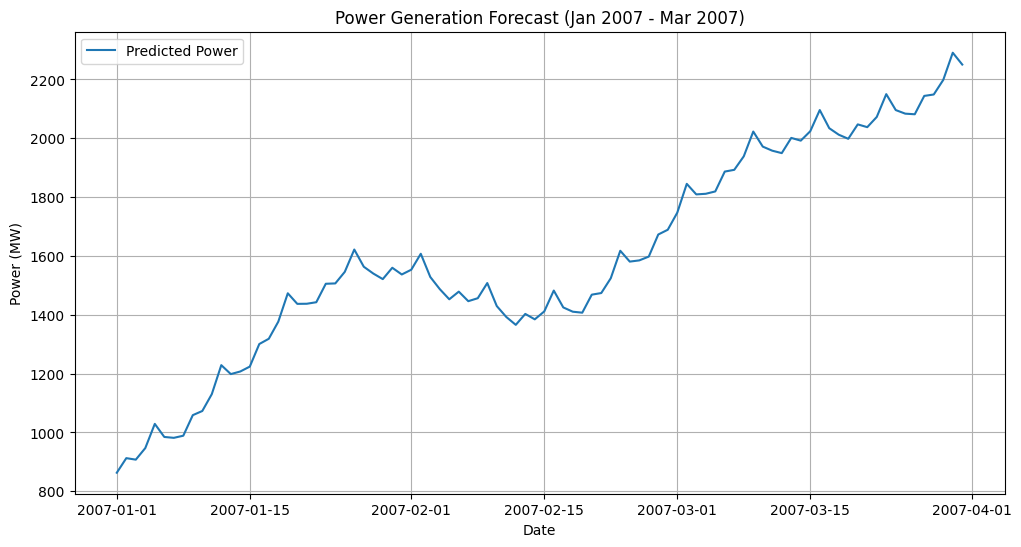

In [229]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Power')
plt.xlabel('Date')
plt.ylabel('Power (MW)')
plt.title('Power Generation Forecast (Jan 2007 - Mar 2007)')
plt.legend()
plt.grid(True)
plt.show()

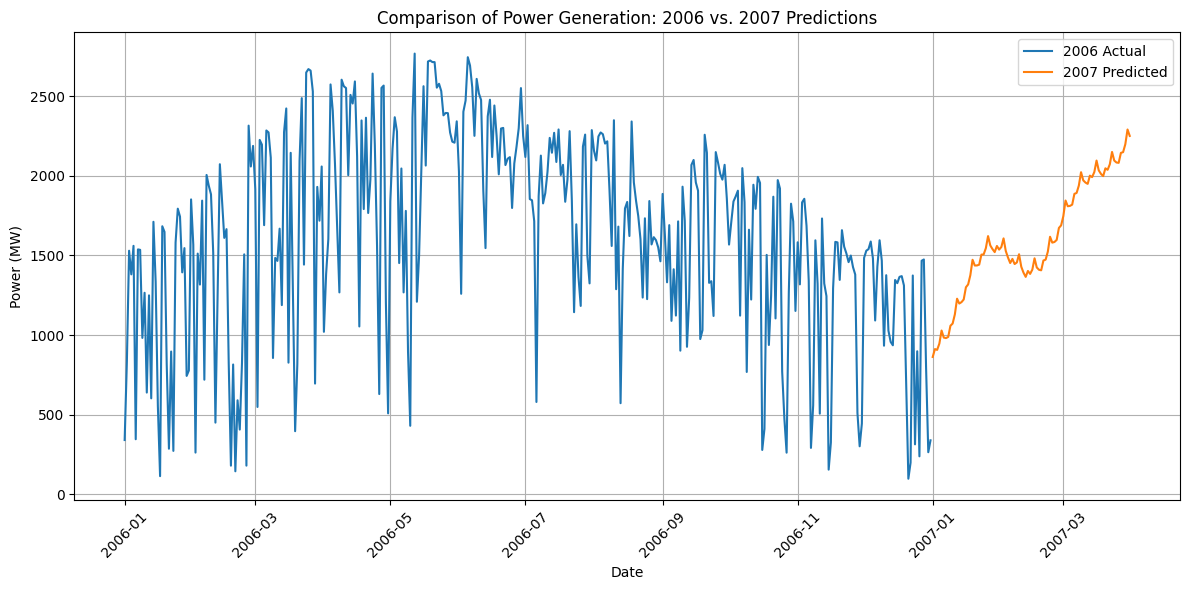

In [230]:
# Filter data for 2006 and 2007
daily_df_2006 = daily_df[daily_df['Date'].dt.year == 2006]
forecast_2007 = forecast[forecast['ds'].dt.year == 2007]

# Extract relevant columns
dates_2006 = daily_df_2006['Date']
power_2006 = daily_df_2006['Power(MW)']
dates_2007 = forecast_2007['ds']
power_2007 = forecast_2007['yhat']


# Create the plot
plt.figure(figsize=(12, 6))

plt.plot(dates_2006, power_2006, label='2006 Actual')
plt.plot(dates_2007, power_2007, label='2007 Predicted')


# Customize the plot
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.title("Comparison of Power Generation: 2006 vs. 2007 Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

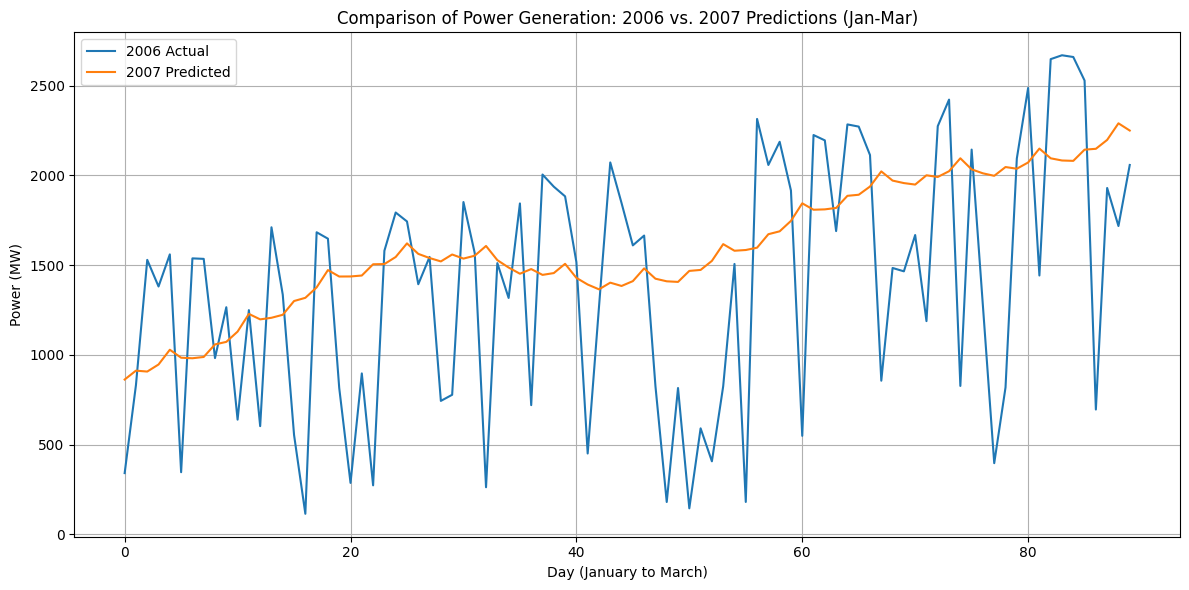

In [231]:
# Filter data for January to March for both years
daily_df_2006_jan_mar = daily_df[(daily_df['Date'].dt.year == 2006) & (daily_df['Date'].dt.month.isin([1, 2, 3]))]
forecast_2007_jan_mar = forecast[(forecast['ds'].dt.year == 2007) & (forecast['ds'].dt.month.isin([1, 2, 3]))]

# Extract power values
power_2006_jan_mar = daily_df_2006_jan_mar['Power(MW)']
power_2007_jan_mar = forecast_2007_jan_mar['yhat']

# Create the plot
plt.figure(figsize=(12, 6))

plt.plot(range(len(power_2006_jan_mar)), power_2006_jan_mar, label='2006 Actual')
plt.plot(range(len(power_2007_jan_mar)), power_2007_jan_mar, label='2007 Predicted')

# Customize the plot
plt.xlabel("Day (January to March)")
plt.ylabel("Power (MW)")
plt.title("Comparison of Power Generation: 2006 vs. 2007 Predictions (Jan-Mar)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1. **Data Preparation**: The time series data is prepared by converting the hourly data to daily data by summing the power generation for each day. The 'LocalTime' column is renamed to 'Date,' and the columns are renamed to 'ds' (datestamp) and 'y' (values), which are the required column names for the Prophet model.  The data is then fitted to the Prophet model, with yearly and weekly seasonality considered.

2. **Model Fitting**: A Prophet model is trained on the daily power generation data from the full year. The model learns the seasonal patterns and trends in the data. Important parameters, such as yearly and weekly seasonality components, are specified during model initialization. The seasonality_mode can also be adjusted.

3. **Future Prediction**:  The trained model is then used to make predictions for the period from January 1, 2007 to March 31, 2007.  A future dataframe is created with the dates for this period, and the `predict` method generates predictions for those dates. The predicted values are ensured to be non-negative.

4. **Visualization and Comparison**: The predicted power generation for the specified period is plotted and visually compared against the actual data from 2006 (and a portion of 2006 for a zoomed-in comparison of the first 3 months of the year).  This visual inspection is important for assessing the accuracy of the forecasts.  The plots allow for a qualitative comparison of the model's predictions relative to historical data.


# Recommendations:

**Recommendation 1: Solar Panel Optimization**
 - Consider optimizing panel orientation and tilt angles to maximize solar irradiance capture throughout the day and across seasons.
 - Explore using higher efficiency solar panels.
 - Implement advanced panel cleaning schedules to prevent dust and debris buildup, which reduces solar irradiance.

**Recommendation 2: Energy Storage Strategies**
 - Implement a robust energy storage system (e.g., batteries) to store excess solar energy generated during peak hours.
 - Use stored energy to supplement power generation during periods of low solar irradiance or cloud cover.
 - Evaluate advanced energy storage technologies (e.g., pumped hydro storage) for long-term storage needs.

**Recommendation 3: Predictive Maintenance**
 - Use the trained model to forecast periods of low solar power generation and adjust maintenance schedules accordingly.
 - Proactive maintenance during periods of low production can help prevent further losses
 - Integrate weather forecasts and model outputs for predictive maintenance scheduling.

**Recommendation 4: Periodic Model Retraining**
 - Periodically retrain the models (RandomForest, Neural Network, and Prophet) with updated data to improve their accuracy and reflect changing environmental factors and seasonal variations.